In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2025-08-09 08:49:41.198968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754729381.574144      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754729381.677452      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 40 classes:
 - Magnetic Resonance (MR) Brain
 - Sural Nerve Neurofibroma
 - Carolis Disease
 - Neurofibromatosis Type 1 (NF1) with Optic Glioma and Intracranial Extension
 - Bilateral Osgood-Schlatter Disease with Chronic Inflammatory Arthritis
 - Low Medial Insertion of Common Bile Duct with Pancreas Divisum
 - Sjögrens Syndrome
 - Optic Glioma
 - Myositis Ossificans Progressiva
 - Congenital Vaginal Cyst
 - Hallervorden-Spatz Disease (now called Pantothenate Kinase-Associated Neurodegeneration)
 - Retinoblastoma with Intracranial Spread Along Cranial Nerve
 - Congenital Toxoplasmosis
 - Leighs Disease in Spinal Cord and Inferior Colliculi
 - Walker-Warburg Syndrome
 - Dermatomyositis
 - Lumbosacral Plexitis
 - Adenomyosis in Gravid Uterus
 - Two-Week Follow-Up with Spectroscopy
 - Plexiform Neurofibroma with Sphenoid Wing Absence
 - Japanese B Encephalitis or Epstein-Barr Encephalitis
 - Fukuyama Muscular Dystrophy
 - Rasmussens Encephalitis
 - Balloon Cell Cortical Dysplasia
 

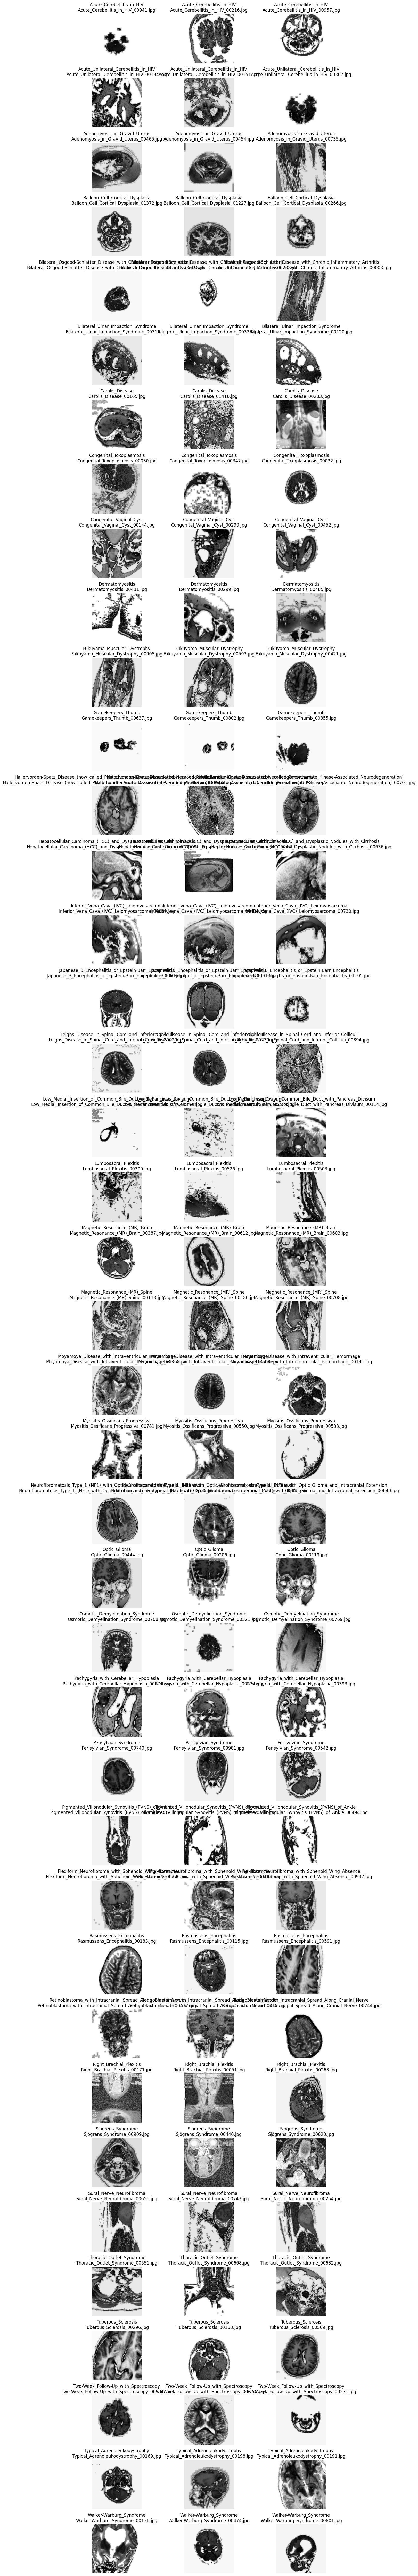

In [2]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

# paths
original_base = Path("/kaggle/input/benchmark/Benchmark Diagnostic MRI and Medical Imaging Dataset/Medical Imaging Dataset")
working_base = Path("/kaggle/working/Medical_Imaging_Cleaned")

# copy data
if working_base.exists():
    shutil.rmtree(working_base)
shutil.copytree(original_base, working_base)

# Finding the class folders
class_folders = []
for root, dirs, files in os.walk(working_base):
    img_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]
    if img_files:
        class_folders.append(Path(root))

print(f"Found {len(class_folders)} classes:")
for f in class_folders:
    print(" -", f.name)

# pre-process and rename all images 
for class_folder in class_folders:
    class_name = class_folder.name.strip().replace(" ", "_")
    for idx, img_path in enumerate(sorted(class_folder.glob("*"))):
        if not img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']:
            continue
        
        img = cv2.imread(str(img_path))  # Read BGR
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Histogram equalization per channel
        channels = cv2.split(img)
        channels = [cv2.equalizeHist(c) for c in channels]
        img = cv2.merge(channels)

        img = cv2.GaussianBlur(img, (5, 5), 0)
        img = cv2.resize(img, (224, 224))

        new_filename = f"{class_name}_{idx:05d}.jpg"
        new_img_path = class_folder / new_filename
        cv2.imwrite(str(new_img_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Save in BGR

        if img_path.name != new_filename:
            img_path.unlink()

print(" All images preprocessed and renamed.")

# Verifying
total_images = 0
errors = []
for class_folder in class_folders:
    class_name = class_folder.name.strip().replace(" ", "_")
    for img_path in class_folder.glob("*.jpg"):
        total_images += 1
        if not img_path.name.startswith(class_name + "_"):
            errors.append(f"Wrong filename: {img_path.name}")
        img = cv2.imread(str(img_path))
        if img is None:
            errors.append(f"Unreadable image: {img_path.name}")
            continue
        if img.shape != (224, 224, 3):
            errors.append(f"Wrong shape {img.shape} in: {img_path.name}")

print(f"\n Verified {total_images} images.")
if errors:
    print(f" Found {len(errors)} issue(s):")
    for err in errors[:10]:
        print(" -", err)
    if len(errors) > 10:
        print("... more issues omitted.")
else:
    print(" All images verified successfully!")

# Display sample images 
print("\n Displaying sample images from each class...")
samples_per_class = 3
fig, axs = plt.subplots(len(class_folders), samples_per_class, figsize=(12, 2.5 * len(class_folders)))

for i, class_folder in enumerate(sorted(class_folders)):
    class_name = class_folder.name.strip().replace(" ", "_")
    all_images = list(class_folder.glob("*.jpg"))
    sample_images = random.sample(all_images, min(samples_per_class, len(all_images)))
    for j, img_path in enumerate(sample_images):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        axs[i, j].set_title(f"{class_name}\n{img_path.name}")

plt.tight_layout()
plt.show()

In [3]:
import os
import random
from pathlib import Path
from shutil import move
from collections import defaultdict
from tqdm import tqdm

random.seed(42)

# Base path to the benchmark dataset 
base_dir = Path('/kaggle/working/Medical_Imaging_Cleaned')

split_base = Path('/kaggle/working/Benchmark_split')
train_dir = split_base / 'train'
val_dir = split_base / 'val'
test_dir = split_base / 'test'

for split in [train_dir, val_dir, test_dir]:
    split.mkdir(parents=True, exist_ok=True)

split_counts = defaultdict(lambda: defaultdict(int))

print("Splitting dataset into train (70%), val (10%), test (20%)...\n")

for class_dir in tqdm(sorted(base_dir.iterdir())):
    if not class_dir.is_dir():
        continue

    label = class_dir.name

    # Recursively find all images inside this class folder
    all_images = list(class_dir.rglob("*.jpg")) + list(class_dir.rglob("*.png")) + list(class_dir.rglob("*.jpeg"))

    if len(all_images) == 0:
        print(f" No images found in: {label}")
        continue

    random.shuffle(all_images)

    total = len(all_images)
    n_train = int(0.7 * total)
    n_val = int(0.1 * total)
    n_test = total - n_train - n_val

    split_sets = {
        train_dir / label: all_images[:n_train],
        val_dir / label: all_images[n_train:n_train + n_val],
        test_dir / label: all_images[n_train + n_val:]
    }

    for split_path, images in split_sets.items():
        split_path.mkdir(parents=True, exist_ok=True)
        for img_path in images:
            move(str(img_path), str(split_path / img_path.name))
            split_counts[split_path.parent.name][label] += 1

print("\n Dataset split completed.")
print("Image counts per class in each split:")

for split in ['train', 'val', 'test']:
    print(f"\n {split.upper()} set:")
    total = 0
    for label, count in sorted(split_counts[split].items()):
        print(f"  {label:20s}: {count}")
        total += count
    print(f"  {'Total':20s}: {total}")

Splitting dataset into train (70%), val (10%), test (20%)...



100%|██████████| 40/40 [00:01<00:00, 29.23it/s]


 Dataset split completed.
Image counts per class in each split:

 TRAIN set:
  Acute Cerebellitis in HIV: 683
  Acute Unilateral Cerebellitis in HIV: 341
  Adenomyosis in Gravid Uterus: 548
  Balloon Cell Cortical Dysplasia: 996
  Bilateral Osgood-Schlatter Disease with Chronic Inflammatory Arthritis: 459
  Bilateral Ulnar Impaction Syndrome: 414
  Carolis Disease     : 1024
  Congenital Toxoplasmosis: 448
  Congenital Vaginal Cyst: 386
  Dermatomyositis     : 403
  Fukuyama Muscular Dystrophy: 644
  Gamekeepers Thumb   : 683
  Hallervorden-Spatz Disease (now called Pantothenate Kinase-Associated Neurodegeneration): 744
  Hepatocellular Carcinoma (HCC) and Dysplastic Nodules with Cirrhosis: 694
  Inferior Vena Cava (IVC) Leiomyosarcoma-20240916T165709Z-001: 627
  Japanese B Encephalitis or Epstein-Barr Encephalitis: 806
  Leighs Disease in Spinal Cord and Inferior Colliculi: 638
  Low Medial Insertion of Common Bile Duct with Pancreas Divisum-20240916T165825Z-001: 503
  Lumbosacral Pl

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import numpy as np
from tqdm import tqdm
from pathlib import Path
from torchvision import transforms

In [5]:
from pathlib import Path
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# path
data_path = Path('/kaggle/working/Benchmark_split')

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Faster processing, compatible with pretrained CNNs
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean/std
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
train_data = datasets.ImageFolder(data_path / "train", transform=transform)
val_data = datasets.ImageFolder(data_path / "val", transform=transform)
test_data = datasets.ImageFolder(data_path / "test", transform=transform)

# Dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Number of classes
num_classes = len(train_data.classes)

# Optional check
print(f" Total bird species (classes): {num_classes}")
print(f" Example classes: {train_data.classes[:5]}")

 Total bird species (classes): 40
 Example classes: ['Acute Cerebellitis in HIV', 'Acute Unilateral Cerebellitis in HIV', 'Adenomyosis in Gravid Uterus', 'Balloon Cell Cortical Dysplasia', 'Bilateral Osgood-Schlatter Disease with Chronic Inflammatory Arthritis']


In [6]:
import random
import numpy as np

def whale_optimization(fitness_func, num_whales=5, max_iter=10, lb=[1e-5, 0.1], ub=[1e-3, 0.5]):
    dim = len(lb)
    whales = np.random.uniform(lb, ub, (num_whales, dim))
    fitness = [fitness_func(w) for w in whales]
    best_whale = whales[np.argmin(fitness)]
    best_fitness = min(fitness)

    for t in range(max_iter):
        a = 2 - t * (2 / max_iter)
        for i in range(num_whales):
            r = np.random.rand(dim)
            A = 2 * a * r - a
            C = 2 * r
            p = np.random.rand()
            if p < 0.5:
                D = abs(C * best_whale - whales[i])
                whales[i] = best_whale - A * D
            else:
                distance_to_best = abs(best_whale - whales[i])
                b = 1  # constant
                l = np.random.uniform(-1, 1)
                whales[i] = distance_to_best * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale

            whales[i] = np.clip(whales[i], lb, ub)

        fitness = [fitness_func(w) for w in whales]
        if min(fitness) < best_fitness:
            best_fitness = min(fitness)
            best_whale = whales[np.argmin(fitness)]
        print(f" Iter {t+1}: Best Fitness = {best_fitness:.4f}, Params = {best_whale}")

    return best_whale


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from timm import create_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_hyperparams(params):
    lr, dropout = params
    dropout = float(dropout)
    
    model = create_model("beit_base_patch16_224", pretrained=True, num_classes=num_classes, drop_rate=dropout)
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=float(lr))
    
    # 1 epoch train, 1 epoch val
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        break  # fast eval (train on just 1 batch)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            break  # fast eval (val on just 1 batch)
    return val_loss


In [8]:
best_params = whale_optimization(
    fitness_func=evaluate_hyperparams,
    num_whales=6,
    max_iter=5,
    lb=[1e-5, 0.1],
    ub=[5e-4, 0.5]
)

best_lr, best_dropout = best_params
print(f"\n Best learning rate: {best_lr}, dropout: {best_dropout}")


model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

 Iter 1: Best Fitness = 3.6134, Params = [4.70564961e-04 5.00000000e-01]
 Iter 2: Best Fitness = 3.6134, Params = [4.70564961e-04 5.00000000e-01]
 Iter 3: Best Fitness = 3.6134, Params = [4.70564961e-04 5.00000000e-01]
 Iter 4: Best Fitness = 3.5892, Params = [0.0005 0.5   ]
 Iter 5: Best Fitness = 3.5641, Params = [3.11698988e-04 3.58750330e-01]

 Best learning rate: 0.0003116989883796273, dropout: 0.35875032964551024


In [9]:
# Before training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

model = create_model("beit_base_patch16_224", pretrained=True, num_classes=num_classes, drop_rate=best_dropout)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

# early stopping parameters 
patience = 5       
best_val_acc = 0.0
epochs_no_improve = 0
max_epochs = 100   


for epoch in range(max_epochs):
    # Training
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    avg_train_loss = train_loss / len(train_loader.dataset)

    # validation
    val_loss, correct, total = 0.0, 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader.dataset)

    # Save metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"\n Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={avg_val_loss:.4f}, Acc={val_acc:.4f}")

    # early Stopping Logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_beit.pth")
        print(" Best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f" No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print(f" Early stopping triggered after {epoch+1} epochs.")
        break


Epoch 1/100: 100%|██████████| 374/374 [15:15<00:00,  2.45s/it]



 Epoch 1: Train Loss=3.0097, Acc=0.1655 | Val Loss=2.2687, Acc=0.3152
 Best model saved.


Epoch 2/100: 100%|██████████| 374/374 [15:17<00:00,  2.45s/it]



 Epoch 2: Train Loss=1.7865, Acc=0.4466 | Val Loss=1.4409, Acc=0.5397
 Best model saved.


Epoch 3/100: 100%|██████████| 374/374 [15:17<00:00,  2.45s/it]



 Epoch 3: Train Loss=1.0868, Acc=0.6419 | Val Loss=0.9333, Acc=0.6889
 Best model saved.


Epoch 4/100: 100%|██████████| 374/374 [15:17<00:00,  2.45s/it]



 Epoch 4: Train Loss=0.6763, Acc=0.7625 | Val Loss=0.6863, Acc=0.7609
 Best model saved.


Epoch 5/100: 100%|██████████| 374/374 [15:19<00:00,  2.46s/it]



 Epoch 5: Train Loss=0.4409, Acc=0.8352 | Val Loss=0.5428, Acc=0.8032
 Best model saved.


Epoch 6/100: 100%|██████████| 374/374 [15:20<00:00,  2.46s/it]



 Epoch 6: Train Loss=0.3548, Acc=0.8602 | Val Loss=0.5708, Acc=0.8020
 No improvement for 1 epoch(s).


Epoch 7/100: 100%|██████████| 374/374 [15:18<00:00,  2.46s/it]



 Epoch 7: Train Loss=0.2699, Acc=0.8896 | Val Loss=0.5590, Acc=0.8167
 Best model saved.


Epoch 8/100: 100%|██████████| 374/374 [15:19<00:00,  2.46s/it]



 Epoch 8: Train Loss=0.2440, Acc=0.8988 | Val Loss=0.5038, Acc=0.8273
 Best model saved.


Epoch 9/100: 100%|██████████| 374/374 [15:17<00:00,  2.45s/it]



 Epoch 9: Train Loss=0.2382, Acc=0.9002 | Val Loss=0.4918, Acc=0.8287
 Best model saved.


Epoch 10/100: 100%|██████████| 374/374 [15:19<00:00,  2.46s/it]



 Epoch 10: Train Loss=0.1997, Acc=0.9172 | Val Loss=0.5246, Acc=0.8264
 No improvement for 1 epoch(s).


Epoch 11/100: 100%|██████████| 374/374 [15:19<00:00,  2.46s/it]



 Epoch 11: Train Loss=0.1755, Acc=0.9248 | Val Loss=0.4553, Acc=0.8443
 Best model saved.


Epoch 12/100: 100%|██████████| 374/374 [15:19<00:00,  2.46s/it]



 Epoch 12: Train Loss=0.1805, Acc=0.9245 | Val Loss=0.4811, Acc=0.8311
 No improvement for 1 epoch(s).


Epoch 13/100: 100%|██████████| 374/374 [15:20<00:00,  2.46s/it]



 Epoch 13: Train Loss=0.1807, Acc=0.9249 | Val Loss=0.4664, Acc=0.8411
 No improvement for 2 epoch(s).


Epoch 14/100: 100%|██████████| 374/374 [15:21<00:00,  2.46s/it]



 Epoch 14: Train Loss=0.1595, Acc=0.9343 | Val Loss=0.4568, Acc=0.8431
 No improvement for 3 epoch(s).


Epoch 15/100: 100%|██████████| 374/374 [15:18<00:00,  2.46s/it]



 Epoch 15: Train Loss=0.1511, Acc=0.9386 | Val Loss=0.4580, Acc=0.8440
 No improvement for 4 epoch(s).


Epoch 16/100: 100%|██████████| 374/374 [15:19<00:00,  2.46s/it]



 Epoch 16: Train Loss=0.1175, Acc=0.9507 | Val Loss=0.5515, Acc=0.8343
 No improvement for 5 epoch(s).
 Early stopping triggered after 16 epochs.


In [12]:
import time
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Best beit model
model.load_state_dict(torch.load("/kaggle/working/best_beit.pth"))
model.eval()

# evaluation 
all_preds = []
all_labels = []
all_probs = []
test_loss = 0.0
total_samples = 0
criterion = torch.nn.CrossEntropyLoss()

start_time = time.time()  # Start timing

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time.time()  # End timing
total_time = end_time - start_time
avg_time_per_image = total_time / total_samples

# evaluation metric
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
cross_entropy = test_loss / total_samples
std_dev = np.std(all_probs, axis=0).mean()

print(f"\n Accuracy             : {acc:.4f}")
print(f" Macro F1 Score      : {f1:.4f}")
print(f" Precision           : {precision:.4f}")
print(f" Recall              : {recall:.4f}")
print(f" Cross Entropy       : {cross_entropy:.4f}")
print(f" Std. Dev Probs      : {std_dev:.4f}")
print(f" Total Inference Time: {total_time:.2f} seconds")
print(f" Avg Time per Image  : {avg_time_per_image:.4f} seconds")

Evaluating: 100%|██████████| 108/108 [01:33<00:00,  1.16it/s]


 Accuracy             : 0.8356
 Macro F1 Score      : 0.8202
 Precision           : 0.8259
 Recall              : 0.8268
 Cross Entropy       : 0.4723
 Std. Dev Probs      : 0.1408
 Total Inference Time: 93.50 seconds
 Avg Time per Image  : 0.0136 seconds


In [15]:
from sklearn.metrics import classification_report
import pandas as pd
# classification report
report_df = pd.DataFrame(classification_report(all_labels, all_preds, target_names=train_data.classes, output_dict=True)).T
display(report_df.style.background_gradient(cmap='Blues'))

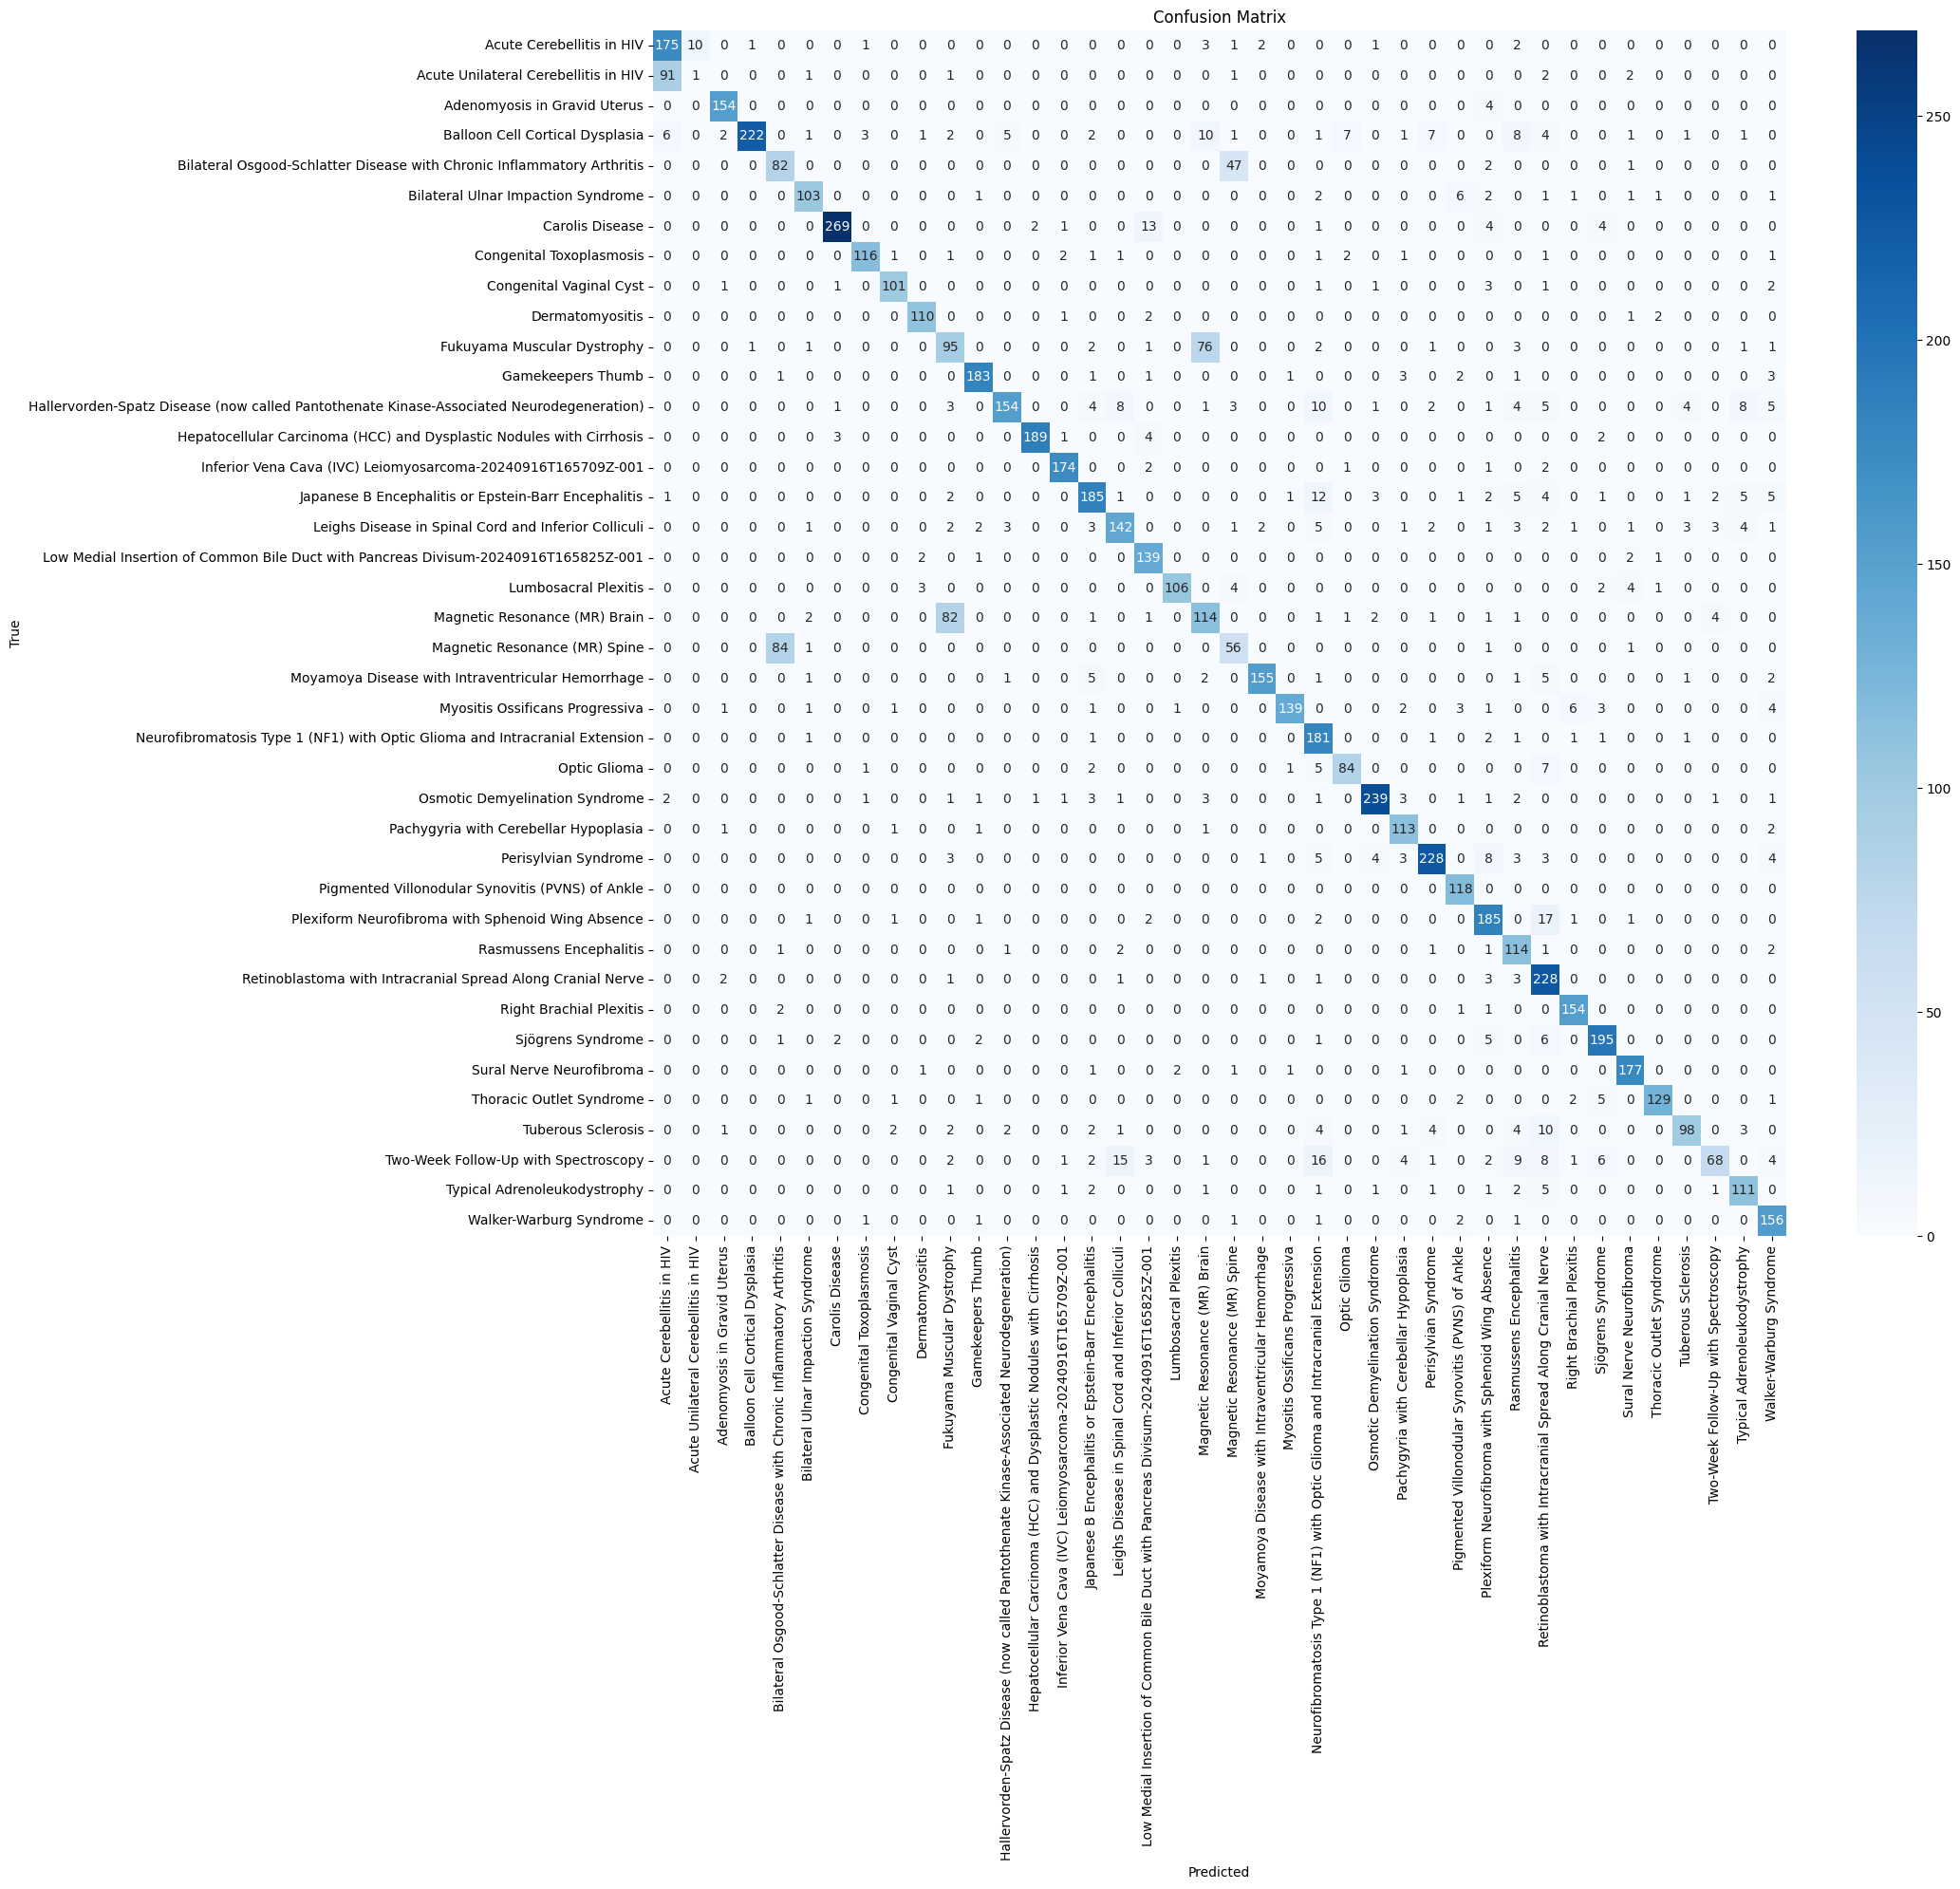

In [18]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(22, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=train_data.classes, 
            yticklabels=train_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

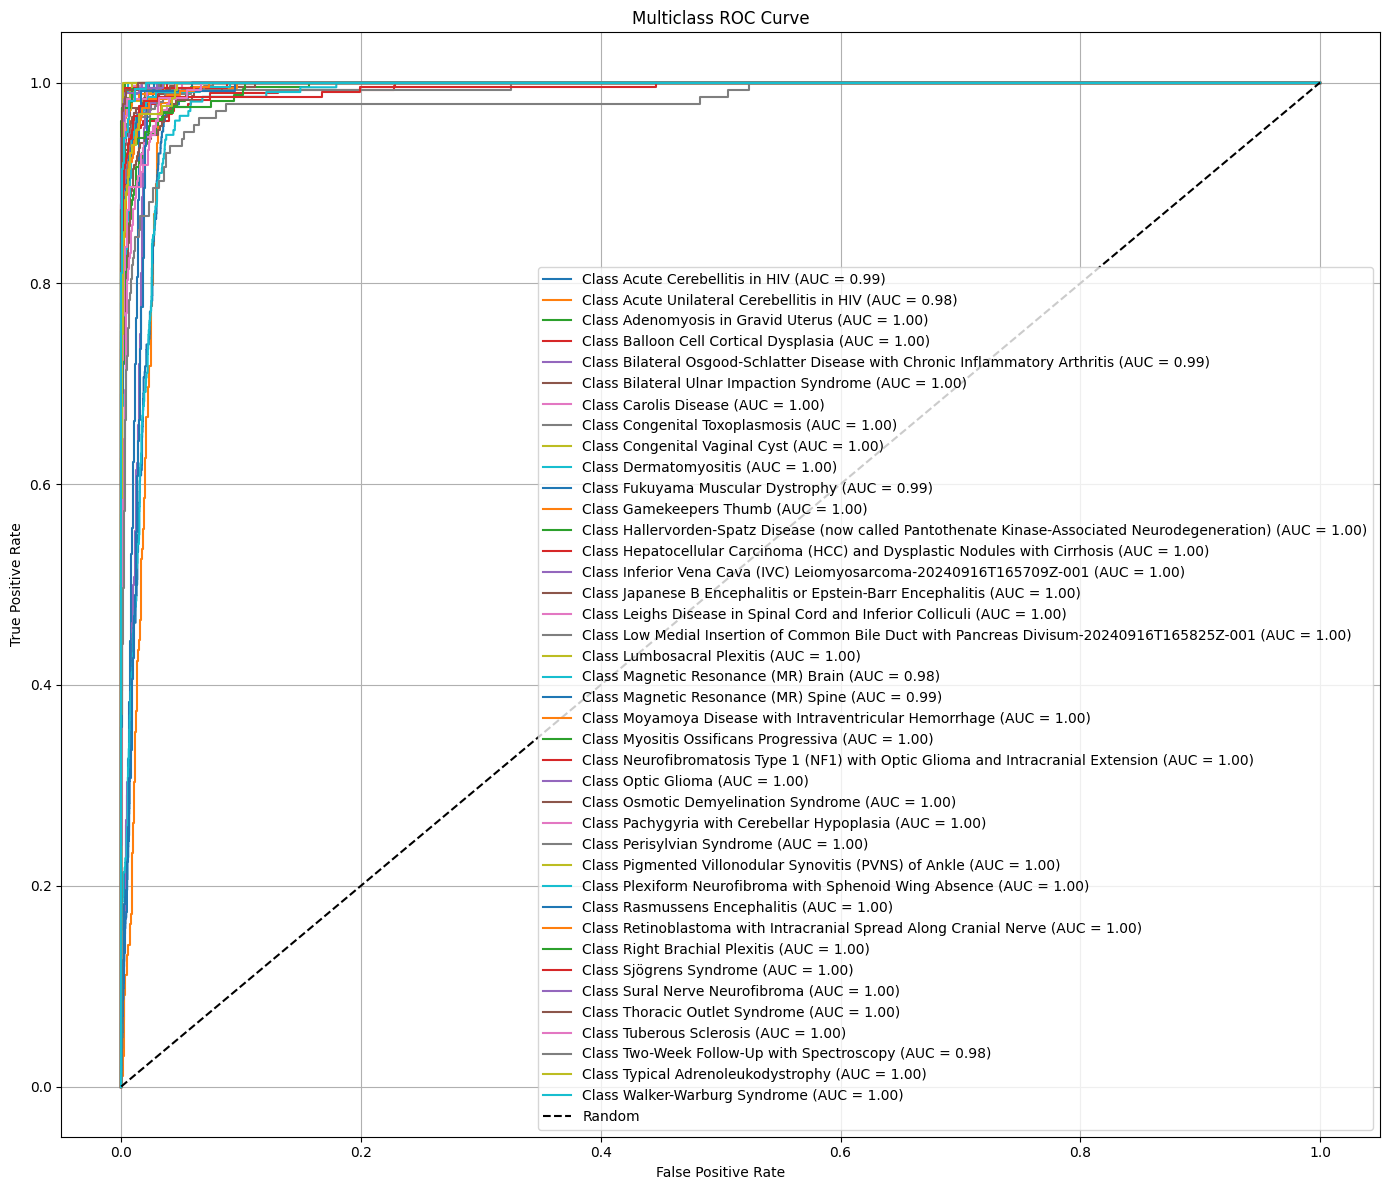

In [22]:
# ROC
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(all_labels))
y_test_bin = label_binarize(all_labels, classes=list(range(n_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(14, 12))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {train_data.classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

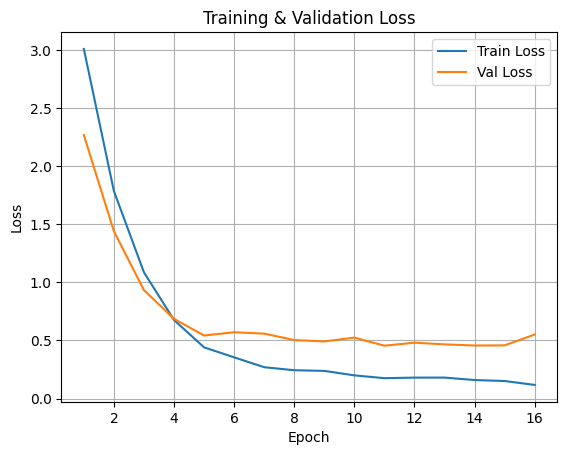

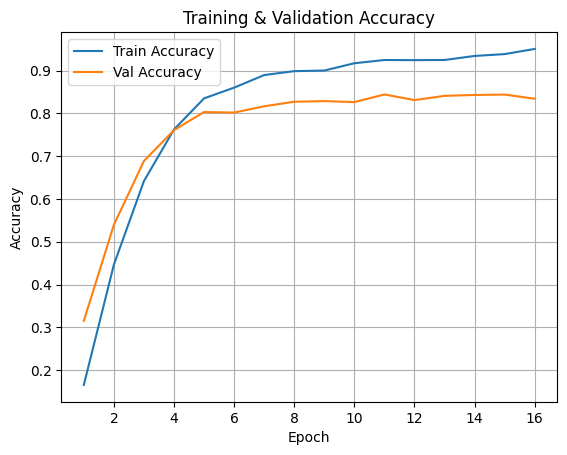

In [23]:
# Training & Validation Curves
epochs = range(1, len(train_losses) + 1)

# Loss
plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Accuracy
plt.figure()
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

In [24]:
model = create_model("beit_base_patch16_224", pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load("/kaggle/working/best_beit.pth"))

<All keys matched successfully>